# Edinburgh bike counter

Arjan Geers

Analysis of [Edinburgh bike counter data](http://www.edinburghopendata.info/dataset/bike-counter-data-set-cluster).

## Preamble

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
import pandas as pd
from bikecounter.data import get_edinburgh_bike_counter_data

## Get data

In [3]:
data = get_edinburgh_bike_counter_data()

In [4]:
data

,01peffermillroad,02steadfastgate,03hawkhillavenue,04seafieldstreet,05blackhall,06silverknowes,07westercoates,08forthroadbridge,09queensferrydalmeny,10rbsgogar,...,39bruntsfieldplacesouthside,40mayfieldroadnorthbound,41mayfieldroadsouthbound,42melvilledrivemain,43melvilledrivespur,44melvilledrivebus1southbound,45melvilledrivebus2northbound,46fishwivescauseway,47inverleithpark,48creweroadsouth
2007-03-29 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Bike counter activity

Total number of active bike counters per month.

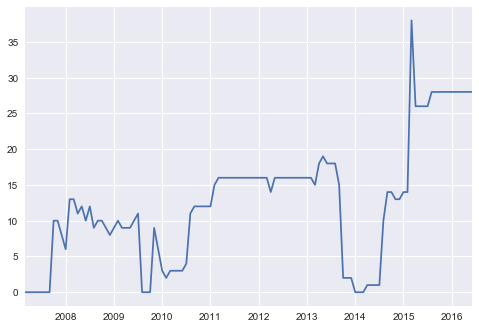

In [5]:
monthly = data.resample('M').sum()
monthly.where(monthly > 0.0).count(axis=1).plot();

Number of bikes per month for each bike counter. It appears that:
1. There are two periods in which few counters were active
2. A different set of counters was active from early 2015 onward than before

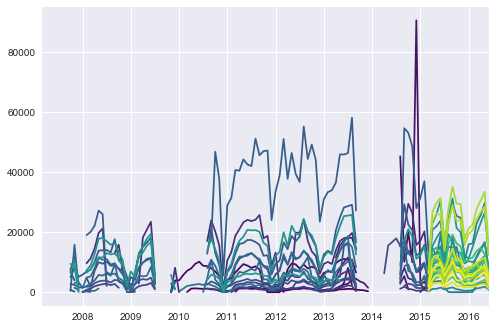

In [6]:
monthly.where(monthly > 0.0).plot(colormap='viridis', legend=False);

Date range of bike counter activity.

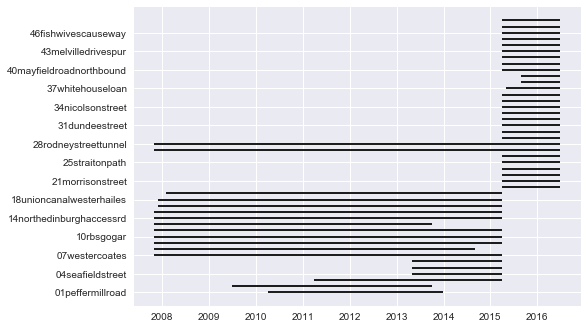

In [7]:
for i, street in enumerate(monthly.columns):
    monthly_street = monthly[street].where(monthly[street] > 0)
    plt.hlines(i,
               monthly_street.first_valid_index(),
               monthly_street.last_valid_index())
plt.yticks(range(0, len(monthly.columns), 3), monthly.columns[::3]);